# 0. Setup 

In [61]:
import os

In [62]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [63]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [64]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [65]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# # Verify Installation
!python {VERIFICATION_SCRIPT}

In [66]:
import object_detection

In [67]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [68]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [69]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

# 2. Load Train Model From Checkpoint

In [70]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [71]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 3. Detect from an Image

In [72]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [73]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [74]:
category_index

{1: {'id': 1, 'name': 'licence'}}

In [102]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'p1.jpg')

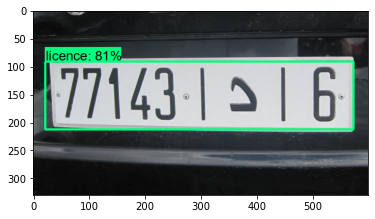

In [103]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR using Yolov3

In [104]:
image = image_np_with_detections
scores1 = detections['detection_scores']
boxes1 = detections['detection_boxes'][:len(scores)]
classes1 = detections['detection_classes'][:len(scores)]

In [105]:
width = image.shape[1]
height = image.shape[0]

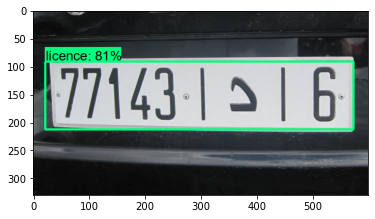

In [106]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [107]:
import cv2
import pytesseract
import numpy as np
import glob

class PlateReader:
    def load_model(self, weight_path: str, cfg_path: str):
        self.net = cv2.dnn.readNet(weight_path, cfg_path)
        with open("classes-ocr.names", "r") as f:
            self.classes = [line.strip() for line in f.readlines()]
        self.layers_names = self.net.getLayerNames()
        self.output_layers = [self.layers_names[i-1] for i in self.net.getUnconnectedOutLayers()]
        self.colors = np.random.uniform(0, 255, size=(len(self.classes), 3))

    def load_image(self, img_path):
        img = cv2.imread(img_path)
        height, width, channels = img.shape
        return img, height, width, channels

    def read_plate(self, img):
        blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        outputs = self.net.forward(self.output_layers)
        return blob, outputs
    
    def get_boxes(self, outputs, width, height, threshold=0.3):
        boxes = []
        confidences = []
        class_ids = []
        for output in outputs:
            for detect in output:
                scores = detect[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > threshold:
                    center_x = int(detect[0] * width)
                    center_y = int(detect[1] * height)
                    w = int(detect[2] * width)
                    h = int(detect[3] * height)
                    x = int(center_x - w/2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
          
        return boxes, confidences, class_ids
    
    def draw_labels(self, boxes, confidences, class_ids, img): 
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
        font = cv2.FONT_HERSHEY_PLAIN
        c = 0
        characters = []
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = round(confidences[i], 3) * 100
                characters.append((label, x))
        characters.sort(key=lambda x:x[1])
        plate = ""
        for l in characters:
            print(l[0])
            plate += l[0]
        return img, plate

    def tesseract_ocr(self, image, lang="eng", psm=7):
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = "-l {} --psm {} -c tessedit_char_whitelist={}".format(lang, psm, alphanumeric)
        return pytesseract.image_to_string(image, config=options)


In [108]:
reader = PlateReader()
reader.load_model("./weights/ocr/yolov3-ocr_final.weights", "./weights/ocr/yolov3-ocr.cfg")

blob, outputs = reader.read_plate(image)
boxes, confidences, class_ids = reader.get_boxes(outputs, width, height, threshold=0.7)
# confidences = scores1[:len(boxes2)]
# class_ids = classes1[:len(boxes2)]
segmented, plate_text = reader.draw_labels(boxes, confidences, class_ids, image)
print('plate_text :: ', plate_text.upper())

7
7
1
4
3
d
6
plate_text ::  77143D6


In [33]:
boxes, confidences, class_ids = reader.get_boxes(outputs, width, height, threshold=0.7)

In [54]:
boxes

[[48, 78, 37, 127],
 [89, 80, 35, 126],
 [130, 85, 34, 117],
 [169, 94, 47, 106],
 [492, 89, 55, 115],
 [169, 95, 46, 107],
 [210, 99, 52, 103],
 [346, 107, 60, 88],
 [492, 93, 56, 113]]

In [50]:
boxes1= boxes1*[height, width, height, width]

In [52]:
boxes2 = []
for b in boxes1 :
    b = list(map(int, b))
    boxes2.append(b)
print(boxes2)

[[92, 21, 212, 574], [129, 0, 258, 600], [82, 0, 213, 402], [121, 38, 216, 459], [154, 0, 330, 600], [78, 73, 226, 322], [52, 111, 251, 485], [70, 0, 250, 600], [45, 18, 266, 412], [0, 0, 165, 533], [0, 0, 42, 131], [137, 270, 176, 301], [226, 0, 330, 600], [83, 299, 226, 536], [0, 13, 184, 381], [140, 0, 330, 600], [44, 13, 169, 554], [0, 0, 227, 598], [0, 0, 20, 77], [0, 62, 330, 532], [0, 0, 157, 312], [0, 84, 70, 357], [73, 70, 192, 441], [89, 193, 230, 433], [59, 0, 330, 600], [0, 0, 330, 600], [0, 108, 197, 483], [182, 0, 330, 600], [0, 0, 168, 600], [109, 313, 170, 415], [113, 0, 330, 600], [0, 209, 70, 448], [130, 139, 189, 241], [128, 260, 170, 297], [0, 425, 43, 600], [184, 1, 202, 26], [107, 0, 284, 600], [107, 0, 186, 343], [0, 0, 56, 187], [61, 114, 205, 352], [142, 1, 159, 24], [198, 109, 330, 518], [0, 0, 38, 77], [0, 0, 240, 600], [177, 1, 194, 26], [191, 0, 210, 26], [138, 0, 216, 293], [101, 43, 237, 250], [0, 0, 14, 52], [0, 0, 84, 275], [150, 0, 167, 24], [135, 1, 1

# -1. Runtime configuration
 

In [1]:
# !pip install protobuf==3.20.* --upgrade
# !pip install tensorflow==2.9.1 --upgrade
# !pip uninstall protobuf matplotlib -y
# !pip install protobuf matplotlib==3.2.2
# pip install opencv-python
# pip install Pillow
# pip install pytz
# pip install pyyaml
# !pip install easyocr
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install pytesseract